# Analysis of N-terminal Extensions Using PhyloCSF

This notebook analyzes candidate N-terminal extensions identified in human genes. We'll examine their conservation patterns using PhyloCSF scores.

## Data Loading
First, let's load the BED12 file containing our N-terminal extension candidates.

In [68]:
import polars as pl
from pathlib import Path

# Define data paths
data_dir = Path("../data/raw")
nte_path = data_dir / "NTEs.bed12"

Load the BED12 file with proper column names. The file contains:
- Genomic coordinates (chrom, start, end)
- Feature names (transcript IDs)
- Strand information
- Block information for the regions

In [69]:
schema = {
    "chrom": pl.Utf8,          # chromosome (string)
    "chromStart": pl.Int64,    # start position
    "chromEnd": pl.Int64,      # end position
    "name": pl.Utf8,           # feature name
    "score": pl.Int64,         # score
    "strand": pl.Utf8,         # strand
    "thickStart": pl.Int64,    # coding start
    "thickEnd": pl.Int64,      # coding end
    "itemRgb": pl.Int64,       # RGB value
    "blockCount": pl.Int64,    # number of blocks
    "blockSizes": pl.Utf8,     # block sizes
    "blockStarts": pl.Utf8     # block starts
}

# Load NTE BED12 file with schema
nte_df = pl.read_csv(
    nte_path,
    separator="\t",
    has_header=False,
    new_columns=[
        "chrom", "chromStart", "chromEnd", "name", "score", 
        "strand", "thickStart", "thickEnd", "itemRgb",
        "blockCount", "blockSizes", "blockStarts"
    ],
    schema=schema
)

nte_df.head()

chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
str,i64,i64,str,i64,str,i64,i64,i64,i64,str,str
"""1""",924053,944153,"""ENST00000616016""",2913,"""+""",924053,944153,0,14,"""895,92,182,51,125,90,138,163,1…","""0,1868,6101,6985,11718,14986,1…"
"""1""",924053,944153,"""ENST00000618323""",2916,"""+""",924053,944153,0,14,"""895,92,182,51,125,90,141,163,1…","""0,1868,6101,6985,11718,14986,1…"
"""1""",1013992,1014478,"""ENST00000624697""",486,"""+""",1013992,1014478,0,1,"""486""","""0"""
"""1""",1013501,1014478,"""ENST00000649529""",570,"""+""",1013501,1014478,0,2,"""75,495""","""0,482"""
"""1""",1020172,1054981,"""ENST00000620552""",6207,"""+""",1020172,1054981,0,39,"""201,262,48,216,225,225,207,219…","""0,2028,15104,20492,21000,21305…"


## Basic Properties of N-terminal Extension Candidates

Let's examine some key characteristics of our candidate regions:
1. Length distribution of extensions
2. Distribution across chromosomes
3. Strand distribution

/tmp/ipykernel_52803/3001962055.py:28: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/tmp/ipykernel_52803/3001962055.py:29: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(pl.col("chrom").map_elements(chr_to_numeric).alias("chr_num"))
/tmp/ipykernel_52803/3001962055.py:37: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  strand_counts = nte_df.group_by("strand").count()


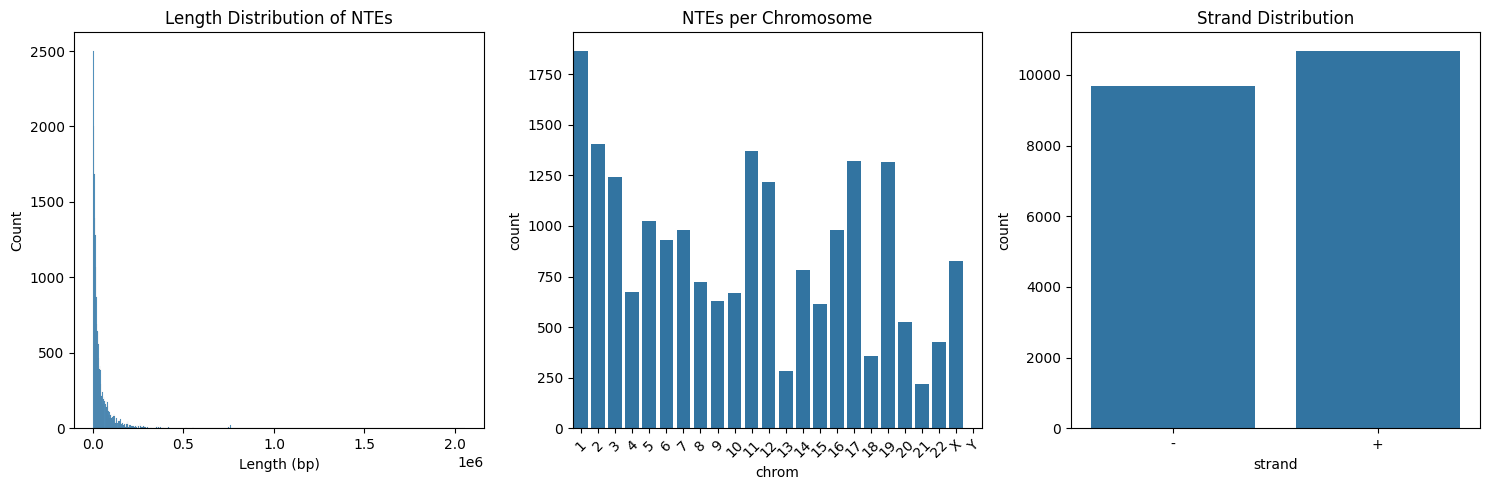


Summary Statistics:
Total number of NTEs: 20372

Length statistics:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ region_length │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 20372.0       │
│ null_count ┆ 0.0           │
│ mean       ┆ 43146.989594  │
│ std        ┆ 79477.093943  │
│ min        ┆ 30.0          │
│ 25%        ┆ 6787.0        │
│ 50%        ┆ 18108.0       │
│ 75%        ┆ 46113.0       │
│ max        ┆ 2.056036e6    │
└────────────┴───────────────┘


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# 1. Length distribution
nte_df = nte_df.with_columns(
    (pl.col("chromEnd") - pl.col("chromStart")).alias("region_length")
)
sns.histplot(data=nte_df.to_pandas(), x="region_length", ax=ax1)
ax1.set_title("Length Distribution of NTEs")
ax1.set_xlabel("Length (bp)")

# 2. Chromosome distribution
def chr_to_numeric(chr_str):
    if chr_str == 'X':
        return 23
    elif chr_str == 'Y':
        return 24
    elif chr_str == 'M' or chr_str == 'MT':
        return 25
    else:
        return int(chr_str)

# Create chromosome distribution plot with numeric sorting
chr_counts = (nte_df.group_by("chrom")
             .count()
             .with_columns(pl.col("chrom").map_elements(chr_to_numeric).alias("chr_num"))
             .sort("chr_num")
             .drop("chr_num"))
sns.barplot(data=chr_counts.to_pandas(), x="chrom", y="count", ax=ax2)
ax2.set_title("NTEs per Chromosome")
ax2.tick_params(axis='x', rotation=45)

# 3. Strand distribution
strand_counts = nte_df.group_by("strand").count()
sns.barplot(data=strand_counts.to_pandas(), x="strand", y="count", ax=ax3)
ax3.set_title("Strand Distribution")

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nSummary Statistics:")
print(f"Total number of NTEs: {len(nte_df)}")
print("\nLength statistics:")
print(nte_df.select(pl.col("region_length")).describe())

# N-terminal Extension Conservation Analysis

We want to analyze the conservation of potential N-terminal extensions (NTEs) relative to their known coding sequences (CDS). This requires:

1. The NTE candidate regions (BED12)
2. GENCODE v47 CDS annotation to identify the original frames
3. PhyloCSF scores to assess coding potential conservation

## Data Loading and Integration

In [71]:
import polars as pl
import pyranges as pr
from pathlib import Path
import pyBigWig
import numpy as np

# Define data paths
data_dir = Path("../data/raw")
gencode_path = data_dir / "gencode.v47.annotation.gtf.gz"

# Load GENCODE annotation
print("Loading GENCODE v47 annotation...")
gr = pr.read_gtf(gencode_path)
cds_annotation = gr[gr.Feature == "CDS"]

print(f"Found {len(cds_annotation)} CDS entries in GENCODE v47")



Loading GENCODE v47 annotation...
Found 901768 CDS entries in GENCODE v47


In [72]:
# Extract transcript IDs and join with CDS information
nte_df = nte_df.with_columns(
    pl.col("name").str.split("_").list.first().alias("transcript_id")
)

# Convert pyranges to polars for joining
cds_df = pl.DataFrame({
    "transcript_id": [i.split('.')[0] for i in cds_annotation.transcript_id.to_list()],
    "strand": cds_annotation.Strand.to_list(),
    "cds_start": cds_annotation.Start.to_list(),
    "cds_end": cds_annotation.End.to_list(),
    "cds_frame": cds_annotation.Frame.to_list(),
    "gene_name": cds_annotation.gene_name.to_list()
})

# Simpler approach: create position columns based on strand
cds_regions = (cds_df
               # First remove version numbers if present
               .with_columns(pl.col("transcript_id").str.split(".").list.first())
               .group_by("transcript_id")
               .agg([
                   pl.col("strand").first().alias("strand"),
                   pl.col("gene_name").first(),
                   pl.col("cds_frame").first().alias("cds_frame"),
                   # Get correct single position based on strand
                   pl.when(pl.col("strand").first() == "+")
                   .then(pl.min("cds_start"))  # Changed this
                   .otherwise(pl.max("cds_end"))  # And this
                   .alias("cds_start_pos")
               ]))


nte_with_cds = (nte_df
                .with_columns(
                    pl.col("name").str.split("_").list.first().alias("transcript_id")
                )
                .join(
                    cds_regions.select([
                        "transcript_id", 
                        "strand",
                        "gene_name",
                        "cds_frame",
                        "cds_start_pos"
                    ]), 
                    on="transcript_id", 
                    how="left",
                    suffix="_cds"  # Add suffix to avoid strand column conflict
                ))

# Look at results
print("\nValidated NTE regions:")
print(nte_with_cds.head())


Validated NTE regions:
shape: (5, 18)
┌───────┬────────────┬──────────┬────────────┬───┬────────────┬───────────┬───────────┬────────────┐
│ chrom ┆ chromStart ┆ chromEnd ┆ name       ┆ … ┆ strand_cds ┆ gene_name ┆ cds_frame ┆ cds_start_ │
│ ---   ┆ ---        ┆ ---      ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ pos        │
│ str   ┆ i64        ┆ i64      ┆ str        ┆   ┆ str        ┆ str       ┆ str       ┆ ---        │
│       ┆            ┆          ┆            ┆   ┆            ┆           ┆           ┆ i64        │
╞═══════╪════════════╪══════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪════════════╡
│ 1     ┆ 924053     ┆ 944153   ┆ ENST000006 ┆ … ┆ +          ┆ SAMD11    ┆ 0         ┆ 924431     │
│       ┆            ┆          ┆ 16016      ┆   ┆            ┆           ┆           ┆            │
│ 1     ┆ 924053     ┆ 944153   ┆ ENST000006 ┆ … ┆ +          ┆ SAMD11    ┆ 0         ┆ 924431     │
│       ┆            ┆          ┆ 18323      ┆   ┆  

In [73]:
cds_df.head()

transcript_id,strand,cds_start,cds_end,cds_frame,gene_name
str,str,i64,i64,str,str
"""ENST00000641515""","""+""",65564,65573,"""0""","""OR4F5"""
"""ENST00000641515""","""+""",69036,70005,"""0""","""OR4F5"""
"""ENST00000616016""","""+""",924431,924948,"""0""","""SAMD11"""
"""ENST00000616016""","""+""",925921,926013,"""2""","""SAMD11"""
"""ENST00000616016""","""+""",930154,930336,"""0""","""SAMD11"""


In [74]:
cds_df.head()

transcript_id,strand,cds_start,cds_end,cds_frame,gene_name
str,str,i64,i64,str,str
"""ENST00000641515""","""+""",65564,65573,"""0""","""OR4F5"""
"""ENST00000641515""","""+""",69036,70005,"""0""","""OR4F5"""
"""ENST00000616016""","""+""",924431,924948,"""0""","""SAMD11"""
"""ENST00000616016""","""+""",925921,926013,"""2""","""SAMD11"""
"""ENST00000616016""","""+""",930154,930336,"""0""","""SAMD11"""


## Loading PhyloCSF Scores for Regions of Interest

We'll create functions to:
1. Load the BigWig files
2. Extract scores for our regions
3. Handle the correct reading frame for each region

In [75]:
import pyBigWig
from pathlib import Path
import numpy as np

def get_phylocsf_for_region(bw_file, chrom, start, end, strand):
    """
    Get PhyloCSF scores for a specific genomic region with coordinate validation
    
    Parameters:
    -----------
    bw_file : pyBigWig.pyBigWig
        Open BigWig file handle
    chrom : str
        Chromosome (with or without 'chr' prefix)
    start : int
        Start position (0-based)
    end : int
        End position
    strand : str
        '+' or '-'
        
    Returns:
    --------
    numpy.ndarray
        Array of PhyloCSF scores or None if no data
    """
    try:
        # Ensure chromosome format matches bigwig
        chrom = f"chr{chrom}" if not chrom.startswith('chr') else chrom
        
        # Check if chromosome exists in bigwig
        if chrom not in bw_file.chroms():
            print(f"Warning: Chromosome {chrom} not found in bigwig")
            return None
            
        # Get chromosome length
        chrom_length = bw_file.chroms(chrom)
        
        # Validate coordinates
        if start < 0 or end < 0:
            print(f"Warning: Negative coordinates ({start}, {end})")
            return None
            
        if end > chrom_length:
            print(f"Warning: End {end} exceeds chromosome length {chrom_length}")
            return None
            
        # Check if region has any data
        if not bw_file.intervals(chrom, start, end):
            print(f"Warning: No data in region {chrom}:{start}-{end}")
            return None
        
        # Get scores
        scores = bw_file.values(chrom, start, end)
        
        # Convert nan to None for easier handling
        scores = np.array(scores)
        scores[np.isnan(scores)] = None
        
        return scores
        
    except Exception as e:
        print(f"Error accessing bigwig: {str(e)}")
        return None


def load_phylocsf_tracks(phylo_dir):
    """
    Load all PhyloCSF bigwig files
    
    Parameters:
    -----------
    phylo_dir : Path
        Directory containing PhyloCSF bigwig files
    
    Returns:
    --------
    dict
        Dictionary of open BigWig file handles
    """
    tracks = {}
    for frame in [1, 2, 3]:
        for strand in ['+', '-']:
            sign = 'plus' if strand == '+' else 'minus'
            filename = f"PhyloCSFRaw_{sign}{frame}.bw"
            filepath = phylo_dir / filename
            if filepath.exists():
                tracks[f"{strand}{frame}"] = pyBigWig.open(str(filepath))
    return tracks

def get_frame_for_extension(strand, phase=0):
    """
    Determine which reading frame we should use for the extension
    based on strand and phase
    
    Parameters:
    -----------
    strand : str
        '+' or '-'
    phase : int
        0, 1, or 2 representing the phase of the CDS
        
    Returns:
    --------
    int
        Frame number (1, 2, or 3)
    """
    # This is a placeholder - need to confirm exact logic
    return ((3 - phase) if strand == '-' else phase) + 1

In [76]:
def load_phylop_track(phylop_path):
    """
    Load PhyloP bigwig file
    
    Parameters:
    -----------
    phylop_path : Path
        Path to PhyloP bigwig file
    
    Returns:
    --------
    pyBigWig.pyBigWig
        Open BigWig file handle
    """
    try:
        return pyBigWig.open(str(phylop_path))
    except Exception as e:
        print(f"Error loading PhyloP bigwig: {str(e)}")
        return None

def get_phylop_for_region(bw_file, chrom, start, end):
    """
    Get PhyloP scores for a specific genomic region
    
    Parameters:
    -----------
    bw_file : pyBigWig.pyBigWig
        Open BigWig file handle
    chrom : str
        Chromosome (with or without 'chr' prefix)
    start : int
        Start position (0-based)
    end : int
        End position
        
    Returns:
    --------
    numpy.ndarray
        Array of PhyloP scores or None if no data
    """
    try:
        # Ensure chromosome format matches bigwig
        chrom = f"chr{chrom}" if not chrom.startswith('chr') else chrom
        
        # Check if chromosome exists in bigwig
        if chrom not in bw_file.chroms():
            print(f"Warning: Chromosome {chrom} not found in bigwig")
            return None
            
        # Get chromosome length
        chrom_length = bw_file.chroms(chrom)
        
        # Validate coordinates
        if start < 0 or end < 0:
            print(f"Warning: Negative coordinates ({start}, {end})")
            return None
            
        if end > chrom_length:
            print(f"Warning: End {end} exceeds chromosome length {chrom_length}")
            return None
            
        # Check if region has any data
        if not bw_file.intervals(chrom, start, end):
            print(f"Warning: No data in region {chrom}:{start}-{end}")
            return None
        
        # Get scores
        scores = bw_file.values(chrom, start, end)
        
        # Convert nan to None for easier handling
        scores = np.array(scores)
        scores[np.isnan(scores)] = None
        
        return scores
        
    except Exception as e:
        print(f"Error accessing bigwig: {str(e)}")
        return None

def compare_phylop_regions(bw_file, regions):
    """
    Compare PhyloP scores across multiple genomic regions
    
    Parameters:
    -----------
    bw_file : pyBigWig.pyBigWig
        Open BigWig file handle
    regions : list of tuples
        List of (chrom, start, end) tuples
        
    Returns:
    --------
    dict
        Dictionary with region coordinates as keys and score arrays as values
    """
    results = {}
    for chrom, start, end in regions:
        key = f"{chrom}:{start}-{end}"
        scores = get_phylop_for_region(bw_file, chrom, start, end)
        if scores is not None:
            results[key] = scores
    return results

In [77]:
def get_frame_and_phylop_scores(phylocsf_handles, phylop_handle, chrom, start, end, strand, score_func=np.nanmean):
    """
    Get both PhyloCSF and PhyloP scores for a region
    
    Parameters:
    -----------
    phylocsf_handles : dict
        Dictionary of open PhyloCSF BigWig handles
    phylop_handle : pyBigWig.pyBigWig
        Open PhyloP BigWig handle
    chrom : str
        Chromosome
    start : int
        Start position
    end : int
        End position
    strand : str
        '+' or '-'
    score_func : function
        Function to aggregate scores (default: np.nanmean)
        
    Returns:
    --------
    tuple
        (phylocsf_scores, phylop_score) where phylocsf_scores is a dict
        of frame scores and phylop_score is a single value
    """
    # Get PhyloCSF frame scores
    phylocsf_scores = {}
    for frame in [1, 2, 3]:
        track_key = f"{strand}{frame}"
        if track_key in phylocsf_handles:
            frame_scores = get_phylocsf_for_region(
                phylocsf_handles[track_key],
                chrom, 
                start, 
                end, 
                strand
            )
            if frame_scores is not None:
                phylocsf_scores[frame] = score_func(frame_scores)
            else:
                phylocsf_scores[frame] = None
    
    # Get PhyloP score
    phylop_scores = get_phylop_for_region(phylop_handle, chrom, start, end)
    phylop_score = score_func(phylop_scores) if phylop_scores is not None else None
    
    return phylocsf_scores, phylop_score

def calculate_all_scores(nte_df, phylocsf_handles, phylop_handle, score_func=np.nanmean):
    """
    Calculate PhyloCSF and PhyloP scores for all NTEs
    
    Parameters:
    -----------
    nte_df : polars.DataFrame
        DataFrame containing NTEs
    phylocsf_handles : dict
        Dictionary of open PhyloCSF BigWig handles
    phylop_handle : pyBigWig.pyBigWig
        Open PhyloP BigWig handle
    score_func : function
        Function to aggregate scores
        
    Returns:
    --------
    polars.DataFrame
        Original DataFrame with added score columns
    """
    frame1_scores = []
    frame2_scores = []
    frame3_scores = []
    phylop_scores = []
    
    for row in nte_df.iter_rows(named=True):
        if row['cds_start_pos']:
            phylocsf_scores, phylop_score = get_frame_and_phylop_scores(
                phylocsf_handles,
                phylop_handle,
                row['chrom'],
                row['chromStart'],
                row['cds_start_pos'],
                row['strand'],
                score_func
            )
            frame1_scores.append(phylocsf_scores.get(1))
            frame2_scores.append(phylocsf_scores.get(2))
            frame3_scores.append(phylocsf_scores.get(3))
            phylop_scores.append(phylop_score)
        else:
            frame1_scores.append(None)
            frame2_scores.append(None)
            frame3_scores.append(None)
            phylop_scores.append(None)
                
    return nte_df.with_columns([
        pl.Series("frame1_score", frame1_scores),
        pl.Series("frame2_score", frame2_scores),
        pl.Series("frame3_score", frame3_scores),
        pl.Series("phylop_score", phylop_scores)
    ])

# Usage example:
phylo_dir = Path("../data/raw/phylocsf")
phylop_path = Path("../data/raw/phyloP/PhyloP_470way.bw")

phylocsf_tracks = load_phylocsf_tracks(phylo_dir)
phylop_track = load_phylop_track(phylop_path)

# Calculate scores for all NTEs
nte_df_with_scores = calculate_all_scores(nte_with_cds, phylocsf_tracks, phylop_track)

# Show first few results
print(nte_df_with_scores.select([
    "chrom", "chromStart", "chromEnd", "strand",
    "frame1_score", "frame2_score", "frame3_score", "phylop_score"
]).head())

Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigwig: Invalid interval bounds!
Error accessing bigw

In [78]:
nte_df_with_scores

chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,region_length,transcript_id,strand_cds,gene_name,cds_frame,cds_start_pos,frame1_score,frame2_score,frame3_score,phylop_score
str,i64,i64,str,i64,str,i64,i64,i64,i64,str,str,i64,str,str,str,str,i64,f64,f64,f64,f64
"""1""",924053,944153,"""ENST00000616016""",2913,"""+""",924053,944153,0,14,"""895,92,182,51,125,90,138,163,1…","""0,1868,6101,6985,11718,14986,1…",20100,"""ENST00000616016""","""+""","""SAMD11""","""0""",924431,-10.18945,-11.075455,-12.825698,0.827685
"""1""",924053,944153,"""ENST00000618323""",2916,"""+""",924053,944153,0,14,"""895,92,182,51,125,90,141,163,1…","""0,1868,6101,6985,11718,14986,1…",20100,"""ENST00000618323""","""+""","""SAMD11""","""0""",924431,-10.18945,-11.075455,-12.825698,0.827685
"""1""",1013992,1014478,"""ENST00000624697""",486,"""+""",1013992,1014478,0,1,"""486""","""0""",486,"""ENST00000624697""","""+""","""ISG15""","""0""",1014004,-12.001583,-1.20575,-6.883667,5.15275
"""1""",1013501,1014478,"""ENST00000649529""",570,"""+""",1013501,1014478,0,2,"""75,495""","""0,482""",977,"""ENST00000649529""","""+""","""ISG15""","""0""",1013573,-26.279936,-40.891952,-32.26855,-0.91575
"""1""",1020172,1054981,"""ENST00000620552""",6207,"""+""",1020172,1054981,0,39,"""201,262,48,216,225,225,207,219…","""0,2028,15104,20492,21000,21305…",34809,"""ENST00000620552""","""+""","""AGRN""","""0""",1022413,-20.061961,-15.439745,-22.191883,1.394694
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""X""",154779176,154805427,"""ENST00000369534""",1455,"""-""",154779176,154805427,0,12,"""177,75,203,81,81,107,197,69,86…","""0,2062,2423,4250,4851,5874,702…",26251,"""ENST00000369534""","""-""","""MPP1""","""0""",154805373,-14.474584,-14.489855,-14.564902,0.192545
"""X""",154804722,154805427,"""ENST00000439370""",261,"""-""",154804722,154805427,0,2,"""105,156""","""0,549""",705,"""ENST00000439370""","""-""","""MPP1""","""0""",154805373,-21.726427,-20.134935,-14.113046,0.947745
"""X""",155061842,155064029,"""ENST00000369484""",213,"""-""",155061842,155064029,0,2,"""149,64""","""0,2123""",2187,"""ENST00000369484""","""-""","""CMC4""","""0""",155064023,-18.219326,-19.200148,-20.385404,1.009138


In [79]:
# Assuming nte_df already has frame1_score, frame2_score, frame3_score columns
nte_df_with_scores = nte_df_with_scores.with_columns(
   pl.max_horizontal([
       "frame1_score",
       "frame2_score", 
       "frame3_score"
   ]).alias("max_frame_score")
)
nte_df_with_scores = nte_df_with_scores.with_columns(
   (pl.col("chrom") + ":" + 
    pl.col("chromStart").cast(pl.Utf8) + "-" +
    pl.col("cds_start_pos").cast(pl.Utf8)
   ).alias("genome_coords")
)
# Verify results
print(nte_df_with_scores.select([
   "transcript_id",
   "frame1_score",
   "frame2_score",
   "frame3_score",
   "genome_coords",
   "max_frame_score"
]).head())

shape: (5, 6)
┌─────────────────┬──────────────┬──────────────┬──────────────┬─────────────────┬─────────────────┐
│ transcript_id   ┆ frame1_score ┆ frame2_score ┆ frame3_score ┆ genome_coords   ┆ max_frame_score │
│ ---             ┆ ---          ┆ ---          ┆ ---          ┆ ---             ┆ ---             │
│ str             ┆ f64          ┆ f64          ┆ f64          ┆ str             ┆ f64             │
╞═════════════════╪══════════════╪══════════════╪══════════════╪═════════════════╪═════════════════╡
│ ENST00000616016 ┆ -10.18945    ┆ -11.075455   ┆ -12.825698   ┆ 1:924053-924431 ┆ -10.18945       │
│ ENST00000618323 ┆ -10.18945    ┆ -11.075455   ┆ -12.825698   ┆ 1:924053-924431 ┆ -10.18945       │
│ ENST00000624697 ┆ -12.001583   ┆ -1.20575     ┆ -6.883667    ┆ 1:1013992-10140 ┆ -1.20575        │
│                 ┆              ┆              ┆              ┆ 04              ┆                 │
│ ENST00000649529 ┆ -26.279936   ┆ -40.891952   ┆ -32.26855    ┆ 1:1013501-10

In [80]:
# Filter for positive max scores and sort by score
positive_ntes = (nte_df_with_scores
               .filter(pl.col("max_frame_score") > 0)
               .sort("max_frame_score", descending=True))

print(f"Found {len(positive_ntes)} NTEs with positive scores")

# Show the best candidates
print("\nTop scoring NTEs:")
print(positive_ntes.select([
   "transcript_id",
   "gene_name",
   "genome_coords", 
   "strand",
   "max_frame_score",
   "frame1_score",
   "frame2_score",
   "frame3_score"
]).head(10))

Found 1840 NTEs with positive scores

Top scoring NTEs:
shape: (10, 8)
┌────────────┬───────────┬────────────┬────────┬────────────┬────────────┬────────────┬────────────┐
│ transcript ┆ gene_name ┆ genome_coo ┆ strand ┆ max_frame_ ┆ frame1_sco ┆ frame2_sco ┆ frame3_sco │
│ _id        ┆ ---       ┆ rds        ┆ ---    ┆ score      ┆ re         ┆ re         ┆ re         │
│ ---        ┆ str       ┆ ---        ┆ str    ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│ str        ┆           ┆ str        ┆        ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
╞════════════╪═══════════╪════════════╪════════╪════════════╪════════════╪════════════╪════════════╡
│ ENST000003 ┆ PROSER2   ┆ 10:1186965 ┆ +      ┆ 49.613667  ┆ 49.613667  ┆ -69.265629 ┆ -50.587518 │
│ 79200      ┆           ┆ 9-11869686 ┆        ┆            ┆            ┆            ┆            │
│ ENST000005 ┆ RPS3A     ┆ 4:15110051 ┆ +      ┆ 45.9622    ┆ -25.287533 ┆ 45.9622    ┆ -28.0324   │
│ 14682      ┆      

In [81]:
nte_df.shape

(20372, 14)

In [82]:
# Convert pyranges to polars for joining with normalized chromosome names
cds_df = pl.DataFrame({
    "transcript_id": [i.split('.')[0] for i in cds_annotation.transcript_id.to_list()],
    "chrom": [str(x).replace('chr', '') for x in cds_annotation.Chromosome.to_list()],  # Remove 'chr' prefix
    "strand": cds_annotation.Strand.to_list(),
    "cds_start": cds_annotation.Start.to_list(),
    "cds_end": cds_annotation.End.to_list(),
    "cds_frame": cds_annotation.Frame.to_list(),
    "gene_name": cds_annotation.gene_name.to_list()
})

# First normalize chromosome names in cds_df
cds_df = cds_df.with_columns(
    pl.col("chrom").str.replace("chr", "").alias("chrom")
)

def find_overlaps_by_chrom(ntes_df, cds_df):
    """
    Process one chromosome at a time to reduce memory usage
    """
    # Get unique chromosomes
    chroms = ntes_df["chrom"].unique().to_list()
    
    overlapping_list = []
    novel_list = []
    
    # Process one chromosome at a time
    for chrom in chroms:
        print(f"Processing chromosome {chrom}")
        
        # Filter both dataframes for current chromosome
        chrom_ntes = ntes_df.filter(pl.col("chrom") == chrom)
        chrom_cds = cds_df.filter(pl.col("chrom") == chrom)
        
        # Check overlaps for this chromosome
        overlaps = (chrom_ntes
            .join(
                chrom_cds,
                on="chrom",
                how="inner"
            )
            .with_columns([
                ((pl.col("chromStart") >= pl.col("cds_start")) & 
                 (pl.col("chromStart") <= pl.col("cds_end"))).alias("has_overlap")
            ])
        )
        
        # Get overlapping transcript IDs for this chromosome
        overlapping_transcripts = (overlaps
            .filter(pl.col("has_overlap"))
            .select("transcript_id")
            .unique()
        )
        
        # Split NTEs into overlapping and novel for this chromosome
        chrom_overlapping = chrom_ntes.join(
            overlapping_transcripts,
            on="transcript_id",
            how="inner"
        )
        
        chrom_novel = chrom_ntes.join(
            overlapping_transcripts,
            on="transcript_id",
            how="anti"
        )
        
        overlapping_list.append(chrom_overlapping)
        novel_list.append(chrom_novel)
        
        # Clear memory
        del overlaps
        del overlapping_transcripts
        del chrom_overlapping
        del chrom_novel
    
    # Combine results
    if overlapping_list:
        overlapping_ntes = pl.concat(overlapping_list)
    else:
        overlapping_ntes = pl.DataFrame(schema=ntes_df.schema)
        
    if novel_list:
        novel_ntes = pl.concat(novel_list)
    else:
        novel_ntes = pl.DataFrame(schema=ntes_df.schema)
    
    return novel_ntes, overlapping_ntes

# Find novel and overlapping NTEs
novel_ntes, overlapping_ntes = find_overlaps_by_chrom(positive_ntes, cds_df)

print(f"\nFound {len(novel_ntes)} novel NTEs that don't overlap any CDS")
print(f"Found {len(overlapping_ntes)} NTEs that overlap with CDS regions")

# Print sample results
print("\nExample novel NTEs:")
print(novel_ntes.select([
   "transcript_id",
   "chrom",
   "chromStart",
   "gene_name", 
   "strand",
   "max_frame_score"
]).head(5))

print("\nExample overlapping NTEs:")
print(overlapping_ntes.select([
   "transcript_id",
   "chrom",
   "chromStart",
   "gene_name", 
   "strand",
   "max_frame_score"
]).head(5))

Processing chromosome 11
Processing chromosome 3
Processing chromosome 16
Processing chromosome 19
Processing chromosome 22
Processing chromosome 12
Processing chromosome 8
Processing chromosome 18
Processing chromosome 4
Processing chromosome 14
Processing chromosome X
Processing chromosome 5
Processing chromosome 10
Processing chromosome 13
Processing chromosome 15
Processing chromosome 21
Processing chromosome 20
Processing chromosome 6
Processing chromosome 17
Processing chromosome 1
Processing chromosome 7
Processing chromosome 2
Processing chromosome 9

Found 1205 novel NTEs that don't overlap any CDS
Found 635 NTEs that overlap with CDS regions

Example novel NTEs:
shape: (5, 6)
┌─────────────────┬───────┬────────────┬───────────┬────────┬─────────────────┐
│ transcript_id   ┆ chrom ┆ chromStart ┆ gene_name ┆ strand ┆ max_frame_score │
│ ---             ┆ ---   ┆ ---        ┆ ---       ┆ ---    ┆ ---             │
│ str             ┆ str   ┆ i64        ┆ str       ┆ str    ┆ f64

In [84]:
from datetime import datetime

# Get current date for versioning
date_str = datetime.now().strftime("%Y%m%d")

# Create output paths
novel_path = f"../data/processed/novel_ntes_{date_str}.parquet"
overlapping_path = f"../data/processed/overlapping_ntes_{date_str}.parquet"

# Write parquet files (efficient storage and maintains data types)
novel_ntes.write_parquet(novel_path)
overlapping_ntes.write_parquet(overlapping_path)

# Also write CSVs for easy viewing
novel_ntes.write_csv(novel_path.replace('.parquet', '.csv'))
overlapping_ntes.write_csv(overlapping_path.replace('.parquet', '.csv'))

print(f"\nWrote {len(novel_ntes)} novel NTEs to:")
print(f"- {novel_path}")
print(f"- {novel_path.replace('.parquet', '.csv')}")

print(f"\nWrote {len(overlapping_ntes)} overlapping NTEs to:")
print(f"- {overlapping_path}")
print(f"- {overlapping_path.replace('.parquet', '.csv')}")


Wrote 1205 novel NTEs to:
- ../data/processed/novel_ntes_20241101.parquet
- ../data/processed/novel_ntes_20241101.csv

Wrote 635 overlapping NTEs to:
- ../data/processed/overlapping_ntes_20241101.parquet
- ../data/processed/overlapping_ntes_20241101.csv


In [85]:
novel_ntes.head()

chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,region_length,transcript_id,strand_cds,gene_name,cds_frame,cds_start_pos,frame1_score,frame2_score,frame3_score,phylop_score,max_frame_score,genome_coords
str,i64,i64,str,i64,str,i64,i64,i64,i64,str,str,i64,str,str,str,str,i64,f64,f64,f64,f64,f64,str
"""11""",30010716,30012741,"""ENST00000328224""",2025,"""-""",30010716,30012741,0,1,"""2025""","""0""",2025,"""ENST00000328224""","""-""","""KCNA4""","""0""",30012678,26.091911,-24.787313,-24.878192,4.993048,26.091911,"""11:30010716-30012678"""
"""11""",78173771,78188615,"""ENST00000340067""",855,"""-""",78173771,78188615,0,2,"""812,43""","""0,14801""",14844,"""ENST00000340067""","""-""","""KCTD21""","""0""",78174554,-26.22742,24.584862,-24.204579,6.060129,24.584862,"""11:78173771-78174554"""
"""11""",119094962,119095430,"""ENST00000530167""",468,"""-""",119094962,119095430,0,1,"""468""","""0""",468,"""ENST00000530167""","""-""","""H2AX""","""0""",119095394,-16.588331,22.53841,-17.753768,5.914711,22.53841,"""11:119094962-119095394"""
"""11""",119094962,119095430,"""ENST00000375167""",468,"""-""",119094962,119095430,0,1,"""468""","""0""",468,"""ENST00000375167""","""-""","""H2AX""","""0""",119095394,-16.588331,22.53841,-17.753768,5.914711,22.53841,"""11:119094962-119095394"""
"""11""",57235861,57237082,"""ENST00000257254""",1221,"""-""",57235861,57237082,0,1,"""1221""","""0""",1221,"""ENST00000257254""","""-""","""APLNR""","""0""",57237004,-21.786534,-25.43717,20.133963,4.748953,20.133963,"""11:57235861-57237004"""


In [86]:
overlapping_ntes

chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,region_length,transcript_id,strand_cds,gene_name,cds_frame,cds_start_pos,frame1_score,frame2_score,frame3_score,phylop_score,max_frame_score,genome_coords
str,i64,i64,str,i64,str,i64,i64,i64,i64,str,str,i64,str,str,str,str,i64,f64,f64,f64,f64,f64,str
"""11""",209289,214350,"""ENST00000527696""",1581,"""+""",209289,214350,0,8,"""711,92,151,96,145,145,120,121""","""0,1281,1909,3126,3325,3547,400…",5061,"""ENST00000527696""","""+""","""RIC8A""","""0""",209292,-40.389,-17.037666,41.165999,5.679334,41.165999,"""11:209289-209292"""
"""11""",63945878,63954479,"""ENST00000542163""",669,"""+""",63945878,63954479,0,7,"""57,53,96,159,84,78,142""","""0,1072,6359,6528,6877,8093,845…",8601,"""ENST00000542163""","""+""","""NAA40""","""0""",63945896,-9.303611,-19.159667,38.361333,6.512611,38.361333,"""11:63945878-63945896"""
"""11""",102114173,102229940,"""ENST00000524575""",1164,"""+""",102114173,102229940,0,8,"""221,116,114,182,48,131,113,239""","""0,48282,71844,91719,95343,1094…",115767,"""ENST00000524575""","""+""","""YAP1""","""0""",102114356,-30.051224,-27.644186,33.464918,4.266153,33.464918,"""11:102114173-102114356"""
"""11""",75165786,75204580,"""ENST00000532236""",1845,"""+""",75165786,75204580,0,11,"""163,234,99,191,103,358,166,164…","""0,3386,3879,6592,22349,27431,3…",38794,"""ENST00000532236""","""+""","""SLCO2B1""","""0""",75165849,32.460571,-33.070762,-27.994492,5.363984,32.460571,"""11:75165786-75165849"""
"""11""",75165786,75204580,"""ENST00000454962""",1512,"""+""",75165786,75204580,0,9,"""163,191,103,358,166,164,65,121…","""0,6592,22349,27431,30727,34437…",38794,"""ENST00000454962""","""+""","""SLCO2B1""","""0""",75165849,32.460571,-33.070762,-27.994492,5.363984,32.460571,"""11:75165786-75165849"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""9""",2161703,2192739,"""ENST00000382183""",720,"""+""",2161703,2192739,0,6,"""200,106,102,133,143,36""","""0,19867,20437,24392,29562,3100…",31036,"""ENST00000382183""","""+""","""SMARCA2""","""0""",2161712,6.506333,-8.401111,8.281,8.342333,8.281,"""9:2161703-2161712"""
"""9""",125748559,125965923,"""ENST00000447726""",1095,"""+""",125748559,125965923,0,8,"""64,242,191,136,166,113,90,93""","""0,167126,181095,186912,212124,…",217364,"""ENST00000447726""","""+""","""PBX3""","""0""",125748574,-15.228666,7.3218,-14.274,6.7544,7.3218,"""9:125748559-125748574"""
"""9""",120798574,120799678,"""ENST00000437707""",1104,"""+""",120798574,120799678,0,1,"""1104""","""0""",1104,"""ENST00000437707""","""+""","""B3GALT9""","""0""",120798943,-26.441699,6.801488,-23.399894,3.60907,6.801488,"""9:120798574-120798943"""


In [87]:
def create_bed_df(nte_df):
    """Convert NTE dataframe to BED format"""
    return (nte_df
        .with_columns([
            # Parse chromosome from genome_coords
            pl.col("genome_coords").str.split(":").list.first().alias("chrom"),
            # Parse start position
            pl.col("genome_coords").str.split(":").list.last().str.split("-").list.first().cast(pl.Int64).alias("start"),
            # Parse end position
            pl.col("genome_coords").str.split(":").list.last().str.split("-").list.last().cast(pl.Int64).alias("end"),
            # Use transcript_id as name
            pl.col("transcript_id").alias("name"),
            # Use max_frame_score as score, scaled to 1000 for BED format
            (pl.col("max_frame_score") * 50 + 500).cast(pl.Int64).alias("score")
        ])
        # Select and order columns for BED format
        .select([
            "chrom",
            "start",
            "end",
            "name",
            "score",
            "strand"
        ])
    )

# Create BED dataframe
bed_df = create_bed_df(nte_df_with_scores)

# Write to BED file
output_path = f"novel_ntes_{date_str}.bed"
bed_df.write_csv(output_path, separator="\t", include_header=False )

print(f"\nWrote BED file to {output_path}")
print("\nFirst few lines of BED file:")
print(bed_df.head(5))


Wrote BED file to novel_ntes_20241101.bed

First few lines of BED file:
shape: (5, 6)
┌───────┬─────────┬─────────┬─────────────────┬───────┬────────┐
│ chrom ┆ start   ┆ end     ┆ name            ┆ score ┆ strand │
│ ---   ┆ ---     ┆ ---     ┆ ---             ┆ ---   ┆ ---    │
│ str   ┆ i64     ┆ i64     ┆ str             ┆ i64   ┆ str    │
╞═══════╪═════════╪═════════╪═════════════════╪═══════╪════════╡
│ 1     ┆ 924053  ┆ 924431  ┆ ENST00000616016 ┆ -9    ┆ +      │
│ 1     ┆ 924053  ┆ 924431  ┆ ENST00000618323 ┆ -9    ┆ +      │
│ 1     ┆ 1013992 ┆ 1014004 ┆ ENST00000624697 ┆ 439   ┆ +      │
│ 1     ┆ 1013501 ┆ 1013573 ┆ ENST00000649529 ┆ -813  ┆ +      │
│ 1     ┆ 1020172 ┆ 1022413 ┆ ENST00000620552 ┆ -271  ┆ +      │
└───────┴─────────┴─────────┴─────────────────┴───────┴────────┘


In [88]:
# Create track header
track_header = """track name="Novel NTEs" description="Novel N-terminal Extensions" visibility=2 useScore=1 color=200,0,0"""

# Write custom track file
output_path = f"novel_ntes_{date_str}.ucsc.bed"

# Convert bed data to string (tab-separated)
bed_data = bed_df.write_csv(separator="\t", include_header=False)

# Write track header and bed data
with open(output_path, 'w') as f:
    f.write(track_header + '\n')  # Write header
    f.write(bed_data)  # Write BED data

print(f"\nWrote UCSC custom track file to {output_path}")
print("\nTrack header:")
print(track_header)
print("\nFirst few lines of track data:")
print(bed_df.head(3))


Wrote UCSC custom track file to novel_ntes_20241101.ucsc.bed

Track header:
track name="Novel NTEs" description="Novel N-terminal Extensions" visibility=2 useScore=1 color=200,0,0

First few lines of track data:
shape: (3, 6)
┌───────┬─────────┬─────────┬─────────────────┬───────┬────────┐
│ chrom ┆ start   ┆ end     ┆ name            ┆ score ┆ strand │
│ ---   ┆ ---     ┆ ---     ┆ ---             ┆ ---   ┆ ---    │
│ str   ┆ i64     ┆ i64     ┆ str             ┆ i64   ┆ str    │
╞═══════╪═════════╪═════════╪═════════════════╪═══════╪════════╡
│ 1     ┆ 924053  ┆ 924431  ┆ ENST00000616016 ┆ -9    ┆ +      │
│ 1     ┆ 924053  ┆ 924431  ┆ ENST00000618323 ┆ -9    ┆ +      │
│ 1     ┆ 1013992 ┆ 1014004 ┆ ENST00000624697 ┆ 439   ┆ +      │
└───────┴─────────┴─────────┴─────────────────┴───────┴────────┘


In [89]:
# Create BED from CDS annotation
cds_bed_df = (cds_df
    .with_columns([
        # Remove 'chr' prefix if present
        pl.col("chrom").str.replace("chr", ""),
        # Use transcript_id as name
        pl.col("transcript_id").alias("name"),
        # Add a score column (default 1000)
        pl.lit(1000).alias("score")
    ])
    .select([
        "chrom",
        "cds_start",  # start position
        "cds_end",    # end position
        "name",       # transcript_id
        "score",
        "strand"
    ])
)

# Write to BED file
cds_bed_path = f"cds_annotation_{date_str}.bed"
cds_bed_df.write_csv(cds_bed_path, separator="\t", include_header=False)

print(f"\nWrote CDS BED file to {cds_bed_path}")
print("\nFirst few lines of CDS BED file:")
print(cds_bed_df.head(5))

print("\nNow you can use bedtools intersect like this:")
print(f"bedtools intersect -v -a novel_ntes_{date_str}.bed -b {cds_bed_path} > novel_ntes_unique_{date_str}.bed")


Wrote CDS BED file to cds_annotation_20241101.bed

First few lines of CDS BED file:
shape: (5, 6)
┌───────┬───────────┬─────────┬─────────────────┬───────┬────────┐
│ chrom ┆ cds_start ┆ cds_end ┆ name            ┆ score ┆ strand │
│ ---   ┆ ---       ┆ ---     ┆ ---             ┆ ---   ┆ ---    │
│ str   ┆ i64       ┆ i64     ┆ str             ┆ i32   ┆ str    │
╞═══════╪═══════════╪═════════╪═════════════════╪═══════╪════════╡
│ 1     ┆ 65564     ┆ 65573   ┆ ENST00000641515 ┆ 1000  ┆ +      │
│ 1     ┆ 69036     ┆ 70005   ┆ ENST00000641515 ┆ 1000  ┆ +      │
│ 1     ┆ 924431    ┆ 924948  ┆ ENST00000616016 ┆ 1000  ┆ +      │
│ 1     ┆ 925921    ┆ 926013  ┆ ENST00000616016 ┆ 1000  ┆ +      │
│ 1     ┆ 930154    ┆ 930336  ┆ ENST00000616016 ┆ 1000  ┆ +      │
└───────┴───────────┴─────────┴─────────────────┴───────┴────────┘

Now you can use bedtools intersect like this:
bedtools intersect -v -a novel_ntes_20241101.bed -b cds_annotation_20241101.bed > novel_ntes_unique_20241101.bed


In [90]:
def create_bed_df(nte_df):
    """Convert NTE dataframe to BED format with proper coordinate ordering"""
    return (nte_df
        .with_columns([
            # Parse chromosome from genome_coords
            pl.col("genome_coords").str.split(":").list.first().alias("chrom"),
            # Parse coordinates
            pl.col("genome_coords").str.split(":").list.last().str.split("-").list.first().cast(pl.Int64).alias("pos1"),
            pl.col("genome_coords").str.split(":").list.last().str.split("-").list.last().cast(pl.Int64).alias("pos2"),
            # Use transcript_id as name
            pl.col("transcript_id").alias("name"),
            # Use max_frame_score as score, scaled to 1000 for BED format
            (pl.col("max_frame_score") * 50 + 500).cast(pl.Int64).alias("score")
        ])
        # Ensure start < end
        .with_columns([
            pl.min_horizontal(["pos1", "pos2"]).alias("start"),
            pl.max_horizontal(["pos1", "pos2"]).alias("end")
        ])
        # Select and order columns for BED format
        .select([
            "chrom",
            "start",
            "end",
            "name",
            "score",
            "strand"
        ])
    )

# Create BED dataframe
bed_df = create_bed_df(novel_ntes)

# Write to BED file
output_path = f"novel_ntes_{date_str}.bed"
bed_df.write_csv(output_path, separator="\t", include_header=False)

print(f"\nWrote BED file to {output_path}")
print("\nFirst few lines of BED file:")
print(bed_df.head(5))

# Create CDS BED with proper ordering
cds_bed_df = (cds_df
    .with_columns([
        # Remove 'chr' prefix if present
        pl.col("chrom").str.replace("chr", ""),
        # Ensure start < end
        pl.min_horizontal(["cds_start", "cds_end"]).alias("start"),
        pl.max_horizontal(["cds_start", "cds_end"]).alias("end"),
        # Use transcript_id as name
        pl.col("transcript_id").alias("name"),
        # Add a score column (default 1000)
        pl.lit(1000).alias("score")
    ])
    .select([
        "chrom",
        "start",
        "end",
        "name",
        "score",
        "strand"
    ])
)

# Write CDS BED file
cds_bed_path = f"cds_annotation_{date_str}.bed"
cds_bed_df.write_csv(cds_bed_path, separator="\t", include_header=False)

print(f"\nWrote CDS BED file to {cds_bed_path}")
print("\nNow you can use bedtools intersect:")
print(f"bedtools intersect -v -a {output_path} -b {cds_bed_path} > novel_ntes_unique_{date_str}.bed")


Wrote BED file to novel_ntes_20241101.bed

First few lines of BED file:
shape: (5, 6)
┌───────┬───────────┬───────────┬─────────────────┬───────┬────────┐
│ chrom ┆ start     ┆ end       ┆ name            ┆ score ┆ strand │
│ ---   ┆ ---       ┆ ---       ┆ ---             ┆ ---   ┆ ---    │
│ str   ┆ i64       ┆ i64       ┆ str             ┆ i64   ┆ str    │
╞═══════╪═══════════╪═══════════╪═════════════════╪═══════╪════════╡
│ 11    ┆ 30010716  ┆ 30012678  ┆ ENST00000328224 ┆ 1804  ┆ -      │
│ 11    ┆ 78173771  ┆ 78174554  ┆ ENST00000340067 ┆ 1729  ┆ -      │
│ 11    ┆ 119094962 ┆ 119095394 ┆ ENST00000530167 ┆ 1626  ┆ -      │
│ 11    ┆ 119094962 ┆ 119095394 ┆ ENST00000375167 ┆ 1626  ┆ -      │
│ 11    ┆ 57235861  ┆ 57237004  ┆ ENST00000257254 ┆ 1506  ┆ -      │
└───────┴───────────┴───────────┴─────────────────┴───────┴────────┘

Wrote CDS BED file to cds_annotation_20241101.bed

Now you can use bedtools intersect:
bedtools intersect -v -a novel_ntes_20241101.bed -b cds_annotation

In [91]:
def create_bed_df(nte_df):
    """Convert NTE dataframe to BED format with proper strand handling"""
    return (nte_df
        .with_columns([
            # Parse chromosome from genome_coords
            pl.col("genome_coords").str.split(":").list.first().alias("chrom"),
            # Parse coordinates
            pl.col("genome_coords").str.split(":").list.last().str.split("-").list.first().cast(pl.Int64).alias("pos1"),
            pl.col("genome_coords").str.split(":").list.last().str.split("-").list.last().cast(pl.Int64).alias("pos2"),
            # Use transcript_id as name
            pl.col("transcript_id").alias("name"),
            # Use max_frame_score as score, scaled to 1000 for BED format
            (pl.col("max_frame_score") * 50 + 500).cast(pl.Int64).alias("score")
        ])
        # Handle coordinates based on strand
        .with_columns([
            pl.when(pl.col("strand") == "+")
            .then(pl.min_horizontal(["pos1", "pos2"]))
            .otherwise(pl.min_horizontal(["pos1", "pos2"]))
            .alias("start"),
            
            pl.when(pl.col("strand") == "+")
            .then(pl.max_horizontal(["pos1", "pos2"]))
            .otherwise(pl.max_horizontal(["pos1", "pos2"]))
            .alias("end")
        ])
        # Select and order columns for BED format
        .select([
            "chrom",
            "start",
            "end",
            "name",
            "score",
            "strand"
        ])
    )

# Print some example records to verify strand handling
print("Example NTEs with coordinates:")
print(novel_ntes.select([
    "transcript_id",
    "strand",
    "genome_coords"
]).head(10))

# Create BED dataframe
bed_df = create_bed_df(novel_ntes)

print("\nSame records in BED format:")
print(bed_df.head(10))

# Write to BED file
output_path = f"novel_ntes_{date_str}.bed"
bed_df.write_csv(output_path, separator="\t", include_header=False)

print(f"\nWrote BED file to {output_path}")

# Create CDS BED
cds_bed_df = (cds_df
    .with_columns([
        # Remove 'chr' prefix if present
        pl.col("chrom").str.replace("chr", ""),
        pl.col("cds_start").alias("start"),
        pl.col("cds_end").alias("end"),
        # Use transcript_id as name
        pl.col("transcript_id").alias("name"),
        # Add a score column (default 1000)
        pl.lit(1000).alias("score")
    ])
    .select([
        "chrom",
        "start",
        "end",
        "name",
        "score",
        "strand"
    ])
)

# Write CDS BED file
cds_bed_path = f"cds_annotation_{date_str}.bed"
cds_bed_df.write_csv(cds_bed_path, separator="\t", include_header=False)

print(f"\nWrote CDS BED file to {cds_bed_path}")
print("\nNow you can use bedtools intersect:")
print(f"bedtools intersect -v -a {output_path} -b {cds_bed_path} > novel_ntes_unique_{date_str}.bed")

Example NTEs with coordinates:
shape: (10, 3)
┌─────────────────┬────────┬────────────────────────┐
│ transcript_id   ┆ strand ┆ genome_coords          │
│ ---             ┆ ---    ┆ ---                    │
│ str             ┆ str    ┆ str                    │
╞═════════════════╪════════╪════════════════════════╡
│ ENST00000328224 ┆ -      ┆ 11:30010716-30012678   │
│ ENST00000340067 ┆ -      ┆ 11:78173771-78174554   │
│ ENST00000530167 ┆ -      ┆ 11:119094962-119095394 │
│ ENST00000375167 ┆ -      ┆ 11:119094962-119095394 │
│ ENST00000257254 ┆ -      ┆ 11:57235861-57237004   │
│ ENST00000606794 ┆ -      ┆ 11:57235861-57237004   │
│ ENST00000356660 ┆ -      ┆ 11:27657820-27658564   │
│ ENST00000533246 ┆ -      ┆ 11:27657820-27658564   │
│ ENST00000305991 ┆ -      ┆ 11:107707834-107707930 │
│ ENST00000531293 ┆ -      ┆ 11:107707834-107707930 │
└─────────────────┴────────┴────────────────────────┘

Same records in BED format:
shape: (10, 6)
┌───────┬───────────┬───────────┬─────────────

In [92]:
import numpy as np
import polars as pl
from typing import List, Optional, Dict

def get_window_scores(scores: np.ndarray, window_size: int = 30) -> List[float]:
    """Calculate scores for sliding windows across the region."""
    if not isinstance(scores, np.ndarray) or len(scores) < window_size:
        return [float(np.mean(scores[~np.isnan(scores)]))]
    
    scores = np.array(scores)
    window_scores = []

    for i in range(len(scores) - window_size + 1):
        window = scores[i:i+window_size]
        # Filter out nan values
        valid_scores = window[~np.isnan(window)]
        if len(valid_scores) > 0:
            window_scores.append(float(np.mean(valid_scores)))

    return window_scores


def longest_positive_run(scores: np.ndarray) -> int:
    """Find the longest continuous run of positive scores."""
    if scores is None or len(scores) == 0:
        return 0
    
    max_run = current_run = 0
    for score in scores:
        if not np.isnan(score) and score > 0:
            current_run += 1
            max_run = max(max_run, current_run)
        else:
            current_run = 0
    return max_run

def analyze_conservation(scores: np.ndarray, window_size: int = 30) -> Dict[str, float]:
    """Compute various conservation metrics for a region."""
    if scores is None or len(scores) == 0:
        return {
            'mean': None,
            'median': None,
            'max': None,
            'q75': None,
            'start_region': None,
            'max_window': None,
            'longest_positive_run': 0
        }
    
    # Convert None to np.nan if scores is a list
    if isinstance(scores, list):
        scores = np.array([s if s is not None else np.nan for s in scores])
    
    # Get window scores
    window_scores = get_window_scores(scores, window_size)
    max_window_score = max(window_scores)
    
    # Get start region score (first 15bp)
    start_scores = scores[:15]
    start_region_mean = np.nanmean(start_scores) if len(start_scores) > 0 else np.nan
    
    # Calculate metrics, handling empty arrays
    try:
        mean_score = np.nanmean(scores)
    except:
        mean_score = np.nan
        
    try:
        median_score = np.nanmedian(scores)
    except:
        median_score = np.nan
        
    try:
        max_score = np.nanmax(scores)
    except:
        max_score = np.nan
        
    try:
        q75_score = np.nanpercentile(scores, 75)
    except:
        q75_score = np.nan
    
    return {
        'mean': mean_score,
        'median': median_score,
        'max': max_score,
        'q75': q75_score,
        'start_region': start_region_mean,
        'max_window': max_window_score,
        'longest_positive_run': longest_positive_run(scores)
    }

def add_conservation_metrics(nte_df: pl.DataFrame, 
                           phylocsf_tracks: dict,
                           window_size: int = 15) -> pl.DataFrame:
    """Add alternative conservation metrics to the NTE DataFrame."""
    
    # Lists to store metrics
    metrics_lists = {
        'mean_score': [],
        'median_score': [],
        'max_score': [],
        'q75_score': [],
        'start_region_score': [],
        'max_window_score': [],
        'longest_positive_run': []
    }
    
    # Calculate metrics for each NTE
    for row in nte_df.iter_rows(named=True):
        scores = get_phylocsf_for_region(
            phylocsf_tracks[f"{row['strand']}1"],  # Using frame 1 for example
            row['chrom'],
            row['chromStart'],
            row['cds_start_pos'],
            row['strand']
        )
        
        metrics = analyze_conservation(scores, window_size)
        for key in metrics_lists:
            metrics_lists[key].append(metrics.get(key.replace('_score', '')))

    # Add new columns to DataFrame
    return nte_df.with_columns([
        pl.Series(name, values) for name, values in metrics_lists.items()
    ])

# Usage example:
# Add conservation metrics to the novel NTEs
novel_ntes_with_metrics = add_conservation_metrics(novel_ntes, phylocsf_tracks)

# Show example results
print("Example NTEs with conservation metrics:")
print(novel_ntes_with_metrics.select([
    "transcript_id",
    "gene_name",
    "mean_score",
    "start_region_score",
    "max_window_score",
    "longest_positive_run"
]).head())

def calculate_correlations(df: pl.DataFrame, correlation_cols: List[str]) -> pl.DataFrame:
    """Calculate correlations, handling missing values properly"""
    # First filter out rows with any nulls
    clean_df = df.drop_nulls(subset=correlation_cols)
    
    # Then calculate correlation
    if len(clean_df) > 0:
        return clean_df.select(correlation_cols).corr()
    else:
        return None

# Use in your code
correlation_cols = [
    "max_frame_score",
    "mean_score", 
    "start_region_score",
    "max_window_score"
]

correlation_matrix = calculate_correlations(novel_ntes_with_metrics, correlation_cols)
if correlation_matrix is not None:
    print("\nCorrelation between conservation metrics:")
    print(correlation_matrix)
else:
    print("\nNot enough complete data for correlation calculation")

/tmp/ipykernel_52803/3273083549.py:60: RuntimeWarning: Mean of empty slice
  start_region_mean = np.nanmean(start_scores) if len(start_scores) > 0 else np.nan


Example NTEs with conservation metrics:
shape: (5, 6)
┌─────────────────┬───────────┬────────────┬──────────────────┬──────────────────┬─────────────────┐
│ transcript_id   ┆ gene_name ┆ mean_score ┆ start_region_sco ┆ max_window_score ┆ longest_positiv │
│ ---             ┆ ---       ┆ ---        ┆ re               ┆ ---              ┆ e_run           │
│ str             ┆ str       ┆ f64        ┆ ---              ┆ f64              ┆ ---             │
│                 ┆           ┆            ┆ f64              ┆                  ┆ i64             │
╞═════════════════╪═══════════╪════════════╪══════════════════╪══════════════════╪═════════════════╡
│ ENST00000328224 ┆ KCNA4     ┆ 26.091911  ┆ 24.8622          ┆ 70.7466          ┆ 399             │
│ ENST00000340067 ┆ KCTD21    ┆ -26.22742  ┆ -33.824067       ┆ 3.2834           ┆ 3               │
│ ENST00000530167 ┆ H2AX      ┆ -16.588331 ┆ -5.705533        ┆ 4.6332           ┆ 9               │
│ ENST00000375167 ┆ H2AX      ┆ -16.5

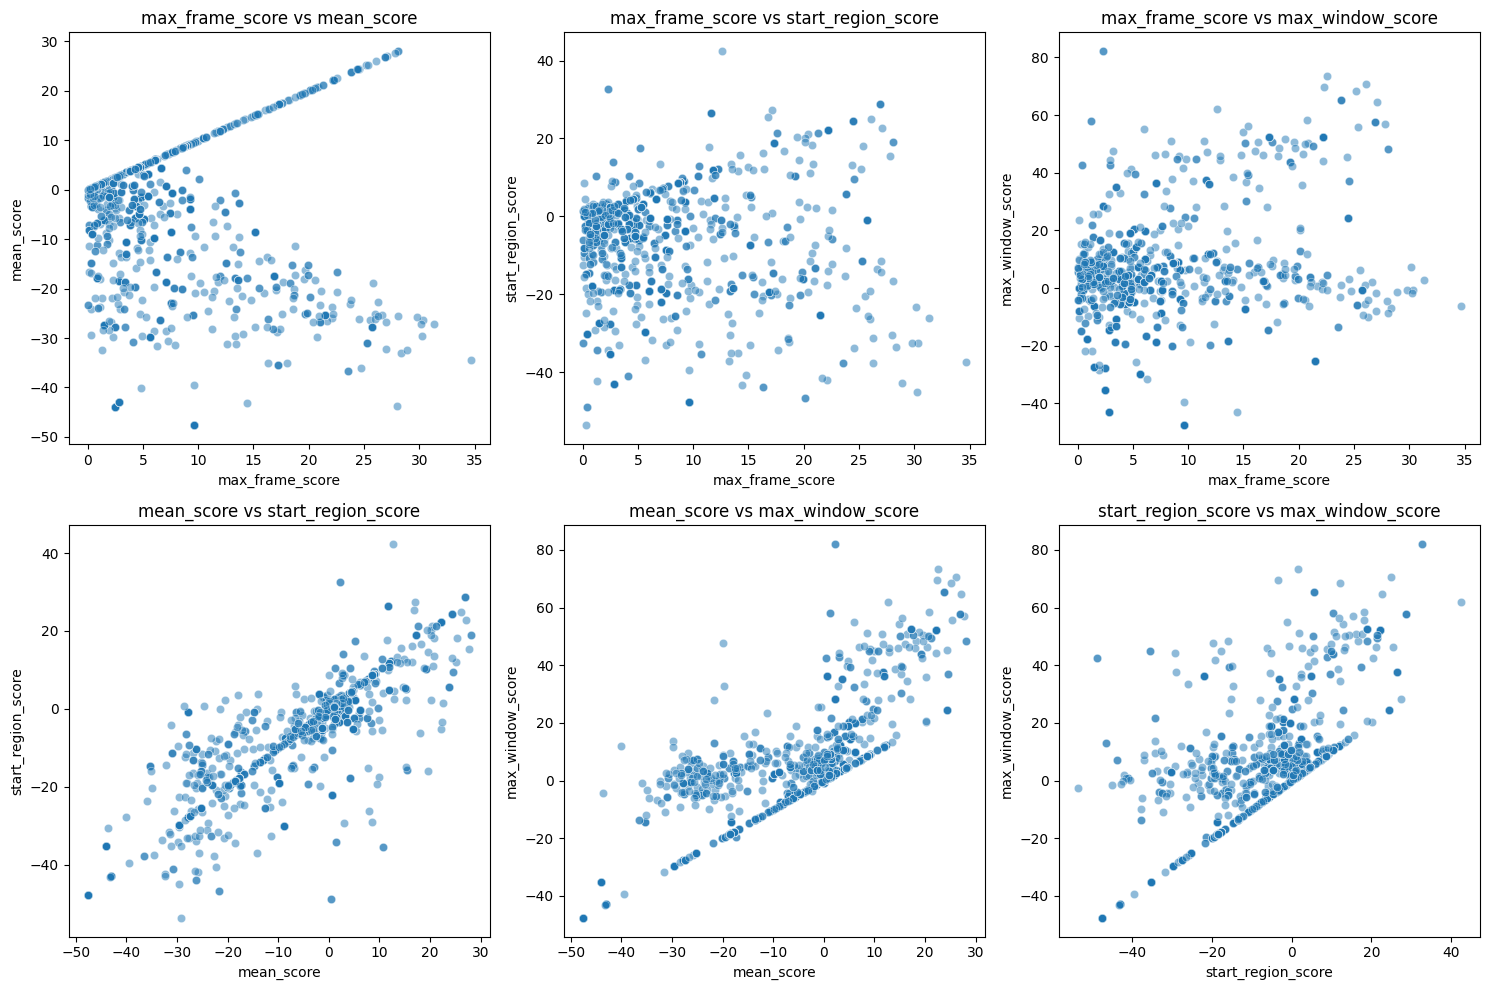

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create correlation plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

pairs = [
    ("max_frame_score", "mean_score"),
    ("max_frame_score", "start_region_score"),
    ("max_frame_score", "max_window_score"),
    ("mean_score", "start_region_score"),
    ("mean_score", "max_window_score"),
    ("start_region_score", "max_window_score")
]

for i, (x, y) in enumerate(pairs):
    sns.scatterplot(
        data=novel_ntes_with_metrics.to_pandas(), 
        x=x, y=y, 
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(f'{x} vs {y}')

plt.tight_layout()
plt.show()

In [94]:
novel_ntes_with_metrics

chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,region_length,transcript_id,strand_cds,gene_name,cds_frame,cds_start_pos,frame1_score,frame2_score,frame3_score,phylop_score,max_frame_score,genome_coords,mean_score,median_score,max_score,q75_score,start_region_score,max_window_score,longest_positive_run
str,i64,i64,str,i64,str,i64,i64,i64,i64,str,str,i64,str,str,str,str,i64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,i64
"""11""",30010716,30012741,"""ENST00000328224""",2025,"""-""",30010716,30012741,0,1,"""2025""","""0""",2025,"""ENST00000328224""","""-""","""KCNA4""","""0""",30012678,26.091911,-24.787313,-24.878192,4.993048,26.091911,"""11:30010716-30012678""",26.091911,18.7415,127.585999,38.716,24.8622,70.7466,399
"""11""",78173771,78188615,"""ENST00000340067""",855,"""-""",78173771,78188615,0,2,"""812,43""","""0,14801""",14844,"""ENST00000340067""","""-""","""KCTD21""","""0""",78174554,-26.22742,24.584862,-24.204579,6.060129,24.584862,"""11:78173771-78174554""",-26.22742,-18.819,47.319,-7.943,-33.824067,3.2834,3
"""11""",119094962,119095430,"""ENST00000530167""",468,"""-""",119094962,119095430,0,1,"""468""","""0""",468,"""ENST00000530167""","""-""","""H2AX""","""0""",119095394,-16.588331,22.53841,-17.753768,5.914711,22.53841,"""11:119094962-119095394""",-16.588331,-11.708,33.132999,-1.76825,-5.705533,4.6332,9
"""11""",119094962,119095430,"""ENST00000375167""",468,"""-""",119094962,119095430,0,1,"""468""","""0""",468,"""ENST00000375167""","""-""","""H2AX""","""0""",119095394,-16.588331,22.53841,-17.753768,5.914711,22.53841,"""11:119094962-119095394""",-16.588331,-11.708,33.132999,-1.76825,-5.705533,4.6332,9
"""11""",57235861,57237082,"""ENST00000257254""",1221,"""-""",57235861,57237082,0,1,"""1221""","""0""",1221,"""ENST00000257254""","""-""","""APLNR""","""0""",57237004,-21.786534,-25.43717,20.133963,4.748953,20.133963,"""11:57235861-57237004""",-21.786534,-17.59,59.241001,-5.338,-46.656668,12.9106,12
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""9""",22008716,22009178,"""ENST00000380142""",462,"""-""",22008716,22009178,0,1,"""462""","""0""",462,"""ENST00000380142""","""-""","""CDKN2B""","""0""",22008953,-17.495359,-24.070683,0.978608,2.873907,0.978608,"""9:22008716-22008953""",-17.495359,-16.414,43.672001,-5.233,-19.746933,4.2296,6
"""9""",134642115,134842303,"""ENST00000371817""",5589,"""+""",134642115,134842303,0,66,"""181,168,214,163,132,138,240,16…","""0,48796,57793,59055,85150,8655…",200188,"""ENST00000371817""","""+""","""COL5A1""","""0""",134642187,0.683833,-8.628764,-2.726667,1.171074,0.683833,"""9:134642115-134642187""",0.683833,-0.169,24.035,4.32175,-4.5924,9.1924,15
"""9""",134642115,134842303,"""ENST00000371820""",5589,"""+""",134642115,134842303,0,66,"""181,168,214,163,132,138,240,16…","""0,48796,57793,59055,85150,8655…",200188,"""ENST00000371820""","""+""","""COL5A1""","""0""",134642187,0.683833,-8.628764,-2.726667,1.171074,0.683833,"""9:134642115-134642187""",0.683833,-0.169,24.035,4.32175,-4.5924,9.1924,15


In [95]:
novel_ntes_with_metrics.columns

['chrom',
 'chromStart',
 'chromEnd',
 'name',
 'score',
 'strand',
 'thickStart',
 'thickEnd',
 'itemRgb',
 'blockCount',
 'blockSizes',
 'blockStarts',
 'region_length',
 'transcript_id',
 'strand_cds',
 'gene_name',
 'cds_frame',
 'cds_start_pos',
 'frame1_score',
 'frame2_score',
 'frame3_score',
 'phylop_score',
 'max_frame_score',
 'genome_coords',
 'mean_score',
 'median_score',
 'max_score',
 'q75_score',
 'start_region_score',
 'max_window_score',
 'longest_positive_run']

In [96]:
novel_ntes_with_metrics.columns

['chrom',
 'chromStart',
 'chromEnd',
 'name',
 'score',
 'strand',
 'thickStart',
 'thickEnd',
 'itemRgb',
 'blockCount',
 'blockSizes',
 'blockStarts',
 'region_length',
 'transcript_id',
 'strand_cds',
 'gene_name',
 'cds_frame',
 'cds_start_pos',
 'frame1_score',
 'frame2_score',
 'frame3_score',
 'phylop_score',
 'max_frame_score',
 'genome_coords',
 'mean_score',
 'median_score',
 'max_score',
 'q75_score',
 'start_region_score',
 'max_window_score',
 'longest_positive_run']

In [97]:
novel_ntes_with_metrics.select(correlation_cols)

max_frame_score,mean_score,start_region_score,max_window_score
f64,f64,f64,f64
26.091911,26.091911,24.8622,70.7466
24.584862,-26.22742,-33.824067,3.2834
22.53841,-16.588331,-5.705533,4.6332
22.53841,-16.588331,-5.705533,4.6332
20.133963,-21.786534,-46.656668,12.9106
…,…,…,…
0.978608,-17.495359,-19.746933,4.2296
0.683833,0.683833,-4.5924,9.1924
0.683833,0.683833,-4.5924,9.1924


In [98]:
def write_scored_bed(df: pl.DataFrame, score_col: str, output_path: str, scale_factor: float = 1000):
    """
    Write BED file with specified score column, handling NaN values
    """
    # First filter out rows with NaN values
    clean_df = df.filter(pl.col(score_col).is_not_nan())
    
    if len(clean_df) == 0:
        print(f"Warning: No valid scores for {score_col}")
        return
    
    bed_df = (clean_df
        .with_columns([
            # Scale and normalize scores to 0-1000 range for visualization
            ((pl.col(score_col) - pl.col(score_col).min()) / 
             (pl.col(score_col).max() - pl.col(score_col).min()) * scale_factor)
            .floor()
            .cast(pl.Int64)
            .clip(0, 1000)  # Ensure scores are in valid range
            .alias("score")
        ])
        .select([
            "chrom",
            pl.col("chromStart").alias("start"),
            pl.col("cds_start_pos").alias("end"),
            "transcript_id",
            "score",
            "strand"
        ]))
    
    print(f"Writing {len(bed_df)} entries for {score_col}")
    bed_df.write_csv(output_path, separator="\t", include_header=False)

# Create BED files for each score type
score_columns = [
    ("mean_score", "mean"),
    ("start_region_score", "start_region"),
    ("max_window_score", "max_window"),
    ("max_frame_score", "max_frame"),
    ("median_score", "median"),
    ("q75_score", "q75"),
    ("longest_positive_run", "positive_run")
]

# Write individual BED files
for score_col, name in score_columns:
    output_path = f"novel_ntes_{date_str}_{name}.bed"
    
    # Print some stats before writing
    print(f"\nProcessing {name} scores:")
    stats = novel_ntes_with_metrics.select(pl.col(score_col)).describe()
    print(stats)
    
    write_scored_bed(novel_ntes_with_metrics, score_col, output_path)
    print(f"Wrote {name} scores to {output_path}")

# Create UCSC track headers
track_colors = {
    "mean": "255,0,0",        # Red
    "start_region": "0,255,0", # Green
    "max_window": "0,0,255",   # Blue
    "max_frame": "255,165,0",  # Orange
    "median": "128,0,128",     # Purple
    "q75": "165,42,42",       # Brown
    "positive_run": "0,128,128" # Teal
}

# Write combined UCSC track file
ucsc_output = f"novel_ntes_{date_str}_all_scores.ucsc.bed"
with open(ucsc_output, 'w') as f:
    # Write each track
    for score_col, name in score_columns:
        bed_path = f"novel_ntes_{date_str}_{name}.bed"
        
        # Only include track if file exists and has content
        if Path(bed_path).exists() and Path(bed_path).stat().st_size > 0:
            # Write track header
            track_line = (f'track name="NTEs_{name}" '
                         f'description="Novel N-terminal Extensions scored by {name}" '
                         f'visibility=2 useScore=1 '
                         f'color={track_colors[name]}')
            f.write(track_line + '\n')
            
            # Write BED data
            with open(bed_path, 'r') as bed_file:
                f.write(bed_file.read())
            f.write('\n')

print(f"\nWrote combined UCSC track file to {ucsc_output}")


Processing mean scores:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ mean_score │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 1205.0     │
│ null_count ┆ 0.0        │
│ mean       ┆ -4.507198  │
│ std        ┆ 14.24465   │
│ min        ┆ -47.663666 │
│ 25%        ┆ -13.553667 │
│ 50%        ┆ -1.367292  │
│ 75%        ┆ 3.948666   │
│ max        ┆ 28.067429  │
└────────────┴────────────┘
Writing 1205 entries for mean_score
Wrote mean scores to novel_ntes_20241101_mean.bed

Processing start_region scores:
shape: (9, 2)
┌────────────┬────────────────────┐
│ statistic  ┆ start_region_score │
│ ---        ┆ ---                │
│ str        ┆ f64                │
╞════════════╪════════════════════╡
│ count      ┆ 1205.0             │
│ null_count ┆ 0.0                │
│ mean       ┆ NaN                │
│ std        ┆ NaN                │
│ min        ┆ -53.645866         │
│ 25%        ┆ -13.553667         │
│ 50%       